In [153]:
import sys
sys.path.append("..")

import Essentials


In [154]:
import numpy as np

from sklearn.preprocessing import StandardScaler
import Essentials
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from abc import ABC, abstractmethod

In [155]:
# Загрузка данных
a = np.load('C:\\Users\\misha\\PLSSVD\\Data_Average.npz', allow_pickle=True)
x_train = a['X_train_1']
x_test = a['X_test_1']

In [156]:
timestamp_train = a['Y_train_1'][:, 1]
timestamp_test = a['Y_test_1'][:, 1]

In [157]:
y_train = a['Y_train_1'][:, 0].reshape(-1, 1).astype(np.float64)
y_test = a['Y_test_1'][:, 0].reshape(-1, 1).astype(np.float64)

C:\Users\misha\AppData\Local\Temp\ipykernel_5396\3088982503.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train = a['Y_train_1'][:, 0].reshape(-1, 1).astype(np.float64)
C:\Users\misha\AppData\Local\Temp\ipykernel_5396\3088982503.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = a['Y_test_1'][:, 0].reshape(-1, 1).astype(np.float64)


In [158]:

class PLSSVDSoftSensor(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train, n_components=2):
        super().__init__(name)
        self.model = None
        self.coefficients = None
        self.n_components = n_components
        self.best_n_components = None  # Добавлен атрибут
        self.best_cv_score = None
        self.train(x_train, y_train, n_components)

    def preprocessing(self, x):
        return x

    def postprocessing(self, y):
        return y

    def evaluate_model(self, x):
        if self.model is None:
            raise ValueError("The model has not been trained yet.")
        return self.model.predict(x)

    def train(self, x_train, y_train, n_components):
        x_train, x_val, y_train, y_val = train_test_split(
            x_train, y_train, test_size=0.2, random_state=42
        )

        best_score = -np.inf
        self.best_n_components = None  
        best_model = None

        for i in range(1, n_components + 1):
            model = PLSRegression(n_components=i)
            model.fit(x_train, y_train)
            score = model.score(x_val, y_val)
            if score > best_score:
                best_score = score
                self.best_n_components = i  # Обновляем атрибут класса
                best_model = model

        if self.best_n_components is None:
            raise ValueError("No suitable number of components found.")

        self.model = best_model
        self.coefficients = best_model.coef_
        self.n_components = self.best_n_components  # Обновляем атрибут класса
        self.best_cv_score = best_score

    def validate(self, x_val, y_val):
        val_score = self.model.score(x_val, y_val)
        print(f"Validation R^2 score: {val_score:.3f}")

    def __str__(self):
        coefs_str = ", ".join([f"{coef:.3f}" for coef in self.coefficients.ravel()])
        return (f"Модель PLSSVD с {self.n_components} компонентами.\n"
                f"Коэффициенты регрессии: {coefs_str}\n"
                f"Лучший R^2 на тестовой выборке: {self.best_cv_score:.3f}")

In [159]:
sensor = PLSSVDSoftSensor(name="PLS Sensor", x_train=x_train, y_train=y_train, n_components=2)

In [160]:
print(sensor)

Модель PLSSVD с 2 компонентами.
Коэффициенты регрессии: 0.117, 0.036, -0.104, 0.081, 0.075, -0.048, 0.007, 0.083, -0.052, 0.030, 0.083, -0.087, 0.139, 0.037, 0.111, 0.044, 0.090, 0.079, -0.153, -0.048, -0.005, -0.176, 0.137, 0.154, 0.005, 0.147, -0.174, 0.099, -0.264, -0.073, -0.026, -0.014, 0.040, 0.114, -0.008, 0.151, -0.208, 0.147, 0.056, -0.130, -0.133, -0.061, 0.049, 0.106, 0.084, 0.037, 0.036, 0.110, 0.069, 0.066, 0.069, 0.070, 0.089, 0.068, 0.090, 0.072, 0.101, -0.084, 0.235, 0.042, 0.029, 0.044, -0.093, 0.047, -0.096, 0.162, -0.117, -0.038, -0.068, 0.071, 0.161, 0.016, -0.003, -0.125, -0.099, 0.042, -0.004, -0.040, 0.037, 0.018, 0.137, 0.174, 0.151, -0.135, 0.052, 0.113, 0.087, -0.017, 0.052, 0.114, -0.038, -0.088, 0.168, -0.087, 0.074, 0.109
Лучший R^2 на тестовой выборке: 0.677


In [161]:
metric = Essentials.R2Metric()

In [162]:
test_visual = Essentials.Visualizer(x_test, y_test, timestamp_test, [metric], 'Test SoftSensor R2 metric')

            Coefficient of determination
PLS Sensor                    -13.794424


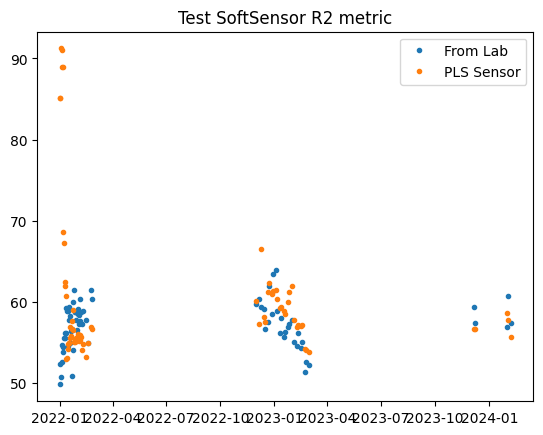

In [163]:
test_visual.visualize([sensor])